In [48]:
! pip install numpy pandas matplotlib seaborn scikit-learn lightgbm shap joblib optuna imbalanced-learn --quiet

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import optuna
import shap

import joblib

import warnings
warnings.filterwarnings('ignore')

In [50]:
from google.colab import files
files.upload()

from IPython.display import clear_output
clear_output()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [51]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          


In [52]:
df = pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [53]:
df.to_csv('creditcard.csv',index=False)

from google.colab import files
files.download('creditcard.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
df.shape

(284807, 31)

In [55]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [56]:
df['Class'].mean()

np.float64(0.001727485630620034)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

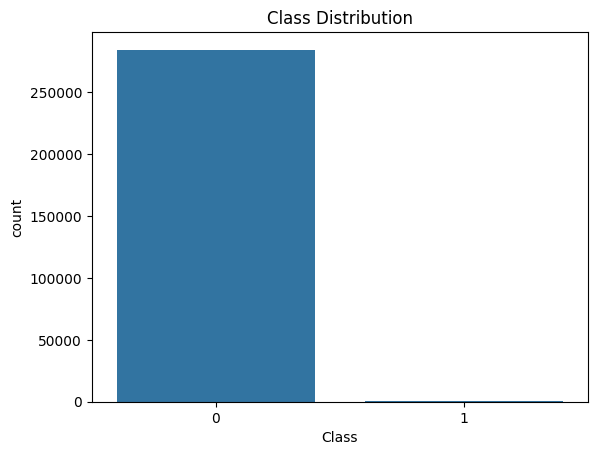

In [58]:
sns.countplot(x='Class',data=df)
plt.title('Class Distribution')
plt.show()

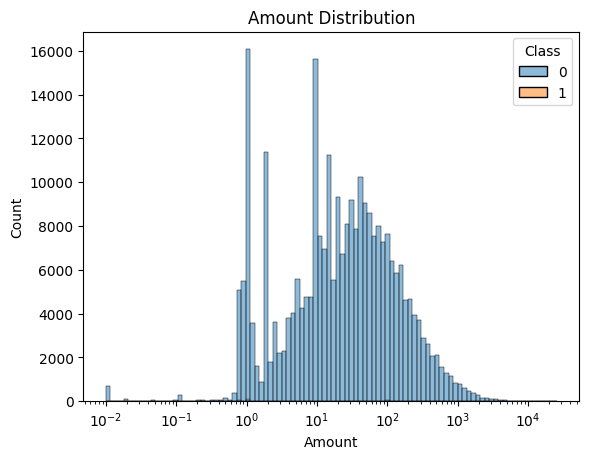

In [59]:
sns.histplot(x=df['Amount'], data=df, hue='Class', log_scale=True,bins=100)
plt.title('Amount Distribution')
plt.show()

In [60]:
X = df.drop(['Time','Class'],axis=1)
y = df['Class']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
num_features = X.columns

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num',num_pipeline,num_features)
])

In [63]:
#model
pipeline = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('smote',SMOTE(random_state=42)),
    ('model',LGBMClassifier(random_state=42,n_jobs=1))
])

In [64]:
def objective(trial):
  params = {
      'n_estimators':trial.suggest_int('n_estimators',100,600),
      'max_depth':trial.suggest_int('max_depth',3,10),
      'learning_rate':trial.suggest_float('learning_rate',0.01,0.5),
      'reg_alpha':trial.suggest_float('reg_alpha',0.0,5.0),
      'reg_lambda':trial.suggest_float('reg_lambda',0.0,5.0),
      'min_child_samples':trial.suggest_int('min_child_samples',10,100),
      'colsample_bytree':trial.suggest_float('colsample_bytree',0.6,1.0),
      'subsample':trial.suggest_float('subsample',0.6,1.0),
      'num_leaves':trial.suggest_int('num_leaves',20,300)
  }

  clf = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('smote',SMOTE(random_state=42)),
    ('model',LGBMClassifier(**params,random_state=42,n_jobs=1))
    ])

  skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  scores = cross_val_score(clf,X_train,y_train,cv=skf,scoring='average_precision',n_jobs=-1)
  return scores.mean()


In [65]:
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=10)

[I 2025-07-28 11:53:10,259] A new study created in memory with name: no-name-9106d49e-c93b-44f2-b89e-ff4d32dc3332
[I 2025-07-28 11:54:45,208] Trial 0 finished with value: 0.8415752087899901 and parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.07199921455320961, 'reg_alpha': 4.9732727952819085, 'reg_lambda': 0.7646552629712056, 'min_child_samples': 100, 'colsample_bytree': 0.6602284884586194, 'subsample': 0.9127439412438344, 'num_leaves': 52}. Best is trial 0 with value: 0.8415752087899901.
[I 2025-07-28 11:56:21,307] Trial 1 finished with value: 0.8444128701044917 and parameters: {'n_estimators': 584, 'max_depth': 8, 'learning_rate': 0.4561323352043424, 'reg_alpha': 2.4985362507366595, 'reg_lambda': 4.850613973011907, 'min_child_samples': 42, 'colsample_bytree': 0.7707774523791947, 'subsample': 0.72569067935251, 'num_leaves': 150}. Best is trial 1 with value: 0.8444128701044917.
[I 2025-07-28 11:58:51,582] Trial 2 finished with value: 0.8466385343255188 and paramet

In [66]:
best_params = study.best_params
print('best params: ',best_params)
best_trial = study.best_trial.value
print('average precision: ',best_trial)

best params:  {'n_estimators': 266, 'max_depth': 6, 'learning_rate': 0.39026650564473797, 'reg_alpha': 4.09820328495369, 'reg_lambda': 3.9700069701082112, 'min_child_samples': 58, 'colsample_bytree': 0.6493396152711911, 'subsample': 0.8044500318781073, 'num_leaves': 77}
average precision:  0.849614299390119


In [106]:
final_pipeline = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('smote',SMOTE(random_state=42)),
    ('model',LGBMClassifier(**best_params,n_jobs=1,random_state=42))
])

In [107]:
final_pipeline.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LGBMClassifier(colsample_bytree=0.6493396152711911,
                                learning_rate=0.39026650564473797, max_depth=6,
                                min_child_samples=58, n_estimators=266,
                                n_jobs=1, num_leaves=77, random_state=42,
                                reg_alpha=4.09820328495369,
                                reg_lambda=3.9700069701082112,
                                subsample=0.8044500318781073))])

In [108]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
y_pred = cross_val_predict(final_pipeline,X_train,y_train,cv=skf,n_jobs=-1,method='predict_proba')[:,1]

In [109]:
from sklearn.metrics import average_precision_score

In [110]:
auprc = average_precision_score(y_train,y_pred)
auprc

np.float64(0.848872437816318)

In [111]:
from sklearn.metrics import precision_recall_curve

In [112]:
precision,recall,threshold = precision_recall_curve(y_train,y_pred)
f1_scores = 2*(precision*recall)/(precision+recall)

best_index = f1_scores.argmax()
print('best_index:', best_index)
best_threshold = threshold[best_index]
print('best_threshold: ', best_threshold)

best_index: 222293
best_threshold:  0.9838574138534868


In [113]:
from sklearn.metrics import classification_report,confusion_matrix,average_precision_score

In [114]:
y_proba = (y_pred>best_threshold).astype(int)
print('classification_report: \n',classification_report(y_train,y_proba))
print('confusion_matrix: \n',confusion_matrix(y_train,y_proba))
print('average_precision_score: \n',average_precision_score(y_train,y_proba))

classification_report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.96      0.79      0.87       394

    accuracy                           1.00    227845
   macro avg       0.98      0.89      0.93    227845
weighted avg       1.00      1.00      1.00    227845

confusion_matrix: 
 [[227437     14]
 [    83    311]]
average_precision_score: 
 0.755702041424083


In [115]:
y_test_proba = final_pipeline.predict_proba(X_test)[:,1]
auprc_test = average_precision_score(y_test,y_test_proba)
print('auprc_test: ', auprc_test)

auprc_test:  0.8743021288332085


In [116]:
final_pipeline.fit(X,y)

[LightGBM] [Info] Number of positive: 284315, number of negative: 284315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 568630, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LGBMClassifier(colsample_bytree=0.6493396152711911,
                                learning_rate=0.39026650564473797, max_depth=6,
                                min_child_samples=58, n_estimators=266,
                                n_jobs=1, num_leaves=77, random_state=42,
                                reg_alpha=4.09820328495369,
                                reg_lambda=3.9700069701082112,
                                subsample=0.8044500318781073))])

In [77]:
from sklearn.model_selection import StratifiedShuffleSplit

In [78]:
sample_size = 5000
splitter = StratifiedShuffleSplit(n_splits=1,test_size=sample_size,random_state=42)

for train_idx, test_idx in splitter.split(X,y):
  X_sample = X.iloc[test_idx]
  y_sample = y.iloc[test_idx]


In [79]:
import shap

In [80]:
X_transformed = final_pipeline.named_steps['preprocessor'].transform(X_sample)
model = final_pipeline.named_steps['model']

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)

In [81]:
def get_feature_names(preprocessor):
  feature_names=[]
  for name,transformer,cols in preprocessor.transformers_:
    if transformer == 'drop':
      continue
    if transformer == 'passthrough':
      feature_names.extend(cols)
    elif hasattr(transformer,'get_feature_names_out'):
      names = transformer.get_feature_names_out(cols)
      feature_names.extend(names)
    else:
      feature_names.extend(cols)

  return feature_names

In [82]:
preprocessor = final_pipeline.named_steps['preprocessor']
encoded_features_names = get_feature_names(preprocessor)

In [105]:
import pandas as pd
import numpy as np

shap_df = pd.DataFrame(np.abs(shap_values),columns=encoded_features_names)

mean_shap_values = shap_df.mean().sort_values(ascending=False)

top_20_features = mean_shap_values.head(20)

print('top_20_features:\n', top_20_features)


top_20_features:
 V14    3.836618
V4     1.872298
V12    1.495417
V1     1.042006
V3     1.024980
V11    0.981866
V8     0.792374
V10    0.745214
V22    0.600458
V18    0.589520
V17    0.561432
V7     0.497061
V27    0.417252
V5     0.401677
V28    0.383903
V25    0.357694
V24    0.338016
V2     0.301277
V15    0.294865
V16    0.284753
dtype: float64


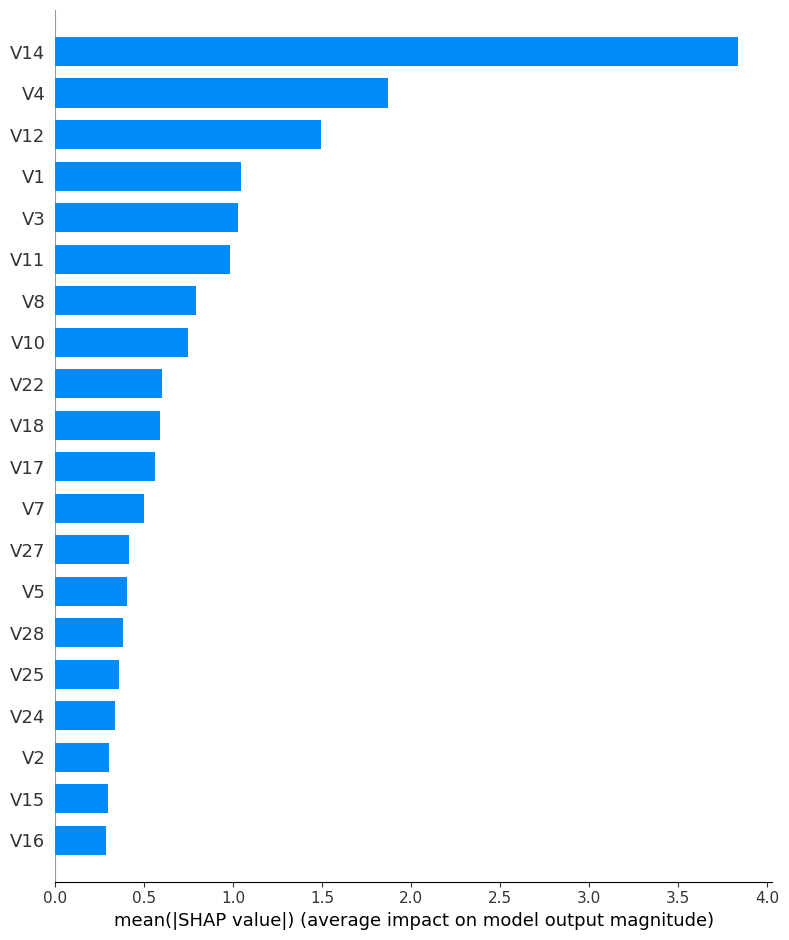

In [83]:
shap.summary_plot(shap_values, X_transformed, feature_names=encoded_features_names,
                  plot_type='bar',max_display=20)


In [95]:
import pandas as pd

num_cols = X.select_dtypes(include=['number']).columns

default_number_values = X[num_cols].median()

print(default_number_values)

V1         0.018109
V2         0.065486
V3         0.179846
V4        -0.019847
V5        -0.054336
V6        -0.274187
V7         0.040103
V8         0.022358
V9        -0.051429
V10       -0.092917
V11       -0.032757
V12        0.140033
V13       -0.013568
V14        0.050601
V15        0.048072
V16        0.066413
V17       -0.065676
V18       -0.003636
V19        0.003735
V20       -0.062481
V21       -0.029450
V22        0.006782
V23       -0.011193
V24        0.040976
V25        0.016594
V26       -0.052139
V27        0.001342
V28        0.011244
Amount    22.000000
dtype: float64


In [96]:
import joblib

In [98]:
joblib.dump(final_pipeline,'fraud_pipeline.pkl')
joblib.dump(default_number_values,'median_values1.pkl')

['median_values1.pkl']

In [99]:
from google.colab import files
files.download('fraud_pipeline.pkl')
files.download('median_values1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
import json

In [93]:
threshold = best_threshold

with open('threshold.json','w') as f:
  json.dump({'threshold':threshold},f)

In [94]:
from google.colab import files

# Download the json
files.download("threshold.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
import sklearn
print(sklearn.__version__)

1.6.1
